# 3. Modeling with a GEO at the US County granularity

Perhaps modeling at the state level doesn't produce insights at a useful granularity. We can easily construct a similar GEO at the county level and run the same simulations.

In [2]:
from epymorph import *
from epymorph.geo import *
from epymorph.geo.adrio import adrio_maker_library
from epymorph.geo.cache import save_to_cache
from epymorph.geo.dynamic import DynamicGeo
from epymorph.geo.spec import attrib
from epymorph.geography.us_census import CountyScope

spec = DynamicGeoSpec(
    attributes=[
        attrib('label', str, Shapes.N),
        attrib('geoid', str, Shapes.N),
        attrib('centroid', CentroidDType, Shapes.N),
        attrib('population', int, Shapes.N),
        attrib('median_income', int, Shapes.N),
        attrib('commuters', int, Shapes.NxN),
    ],
    time_period=Year(2020),
    scope=CountyScope.in_states_by_code(["AZ", "NM", "CO", "UT"]),
    source={
        'label': 'Census:name',
        'geoid': 'Census',
        'centroid': 'Census',
        'population': 'Census',
        'median_income': 'Census',
        'commuters': 'Census',
    }
)

geo = DynamicGeo.from_library(spec, adrio_maker_library)

# It's convenient to pre-fetch the data but this isn't mandatory.
geo.fetch_all()

# Let's inspect a few values...
print(f"nodes: {geo.nodes}")
print(f"label: {geo['label'][0:5]}")
print(f"population: {geo['population'][0:5]}")

# Then save it to a cache so we don't bother the Census API too much.
save_to_cache(geo, 'demo-four-states-by-county')

nodes: 141
label: ['Apache County, Arizona' 'Cochise County, Arizona'
 'Coconino County, Arizona' 'Gila County, Arizona'
 'Graham County, Arizona']
population: [ 71714 126442 142254  53846  38304]


## Centroids movement

Our first movement model is a simple distance kernel using node centroid coordinates (longitude/latitude).

Running simulation (StandardSimulation):
• 2015-01-01 to 2015-05-31 (150 days)
• 141 geo nodes
|####################| 100% 
Runtime: 12.686s


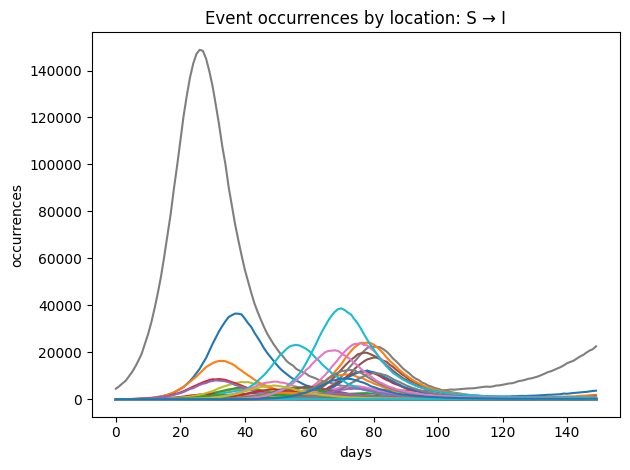

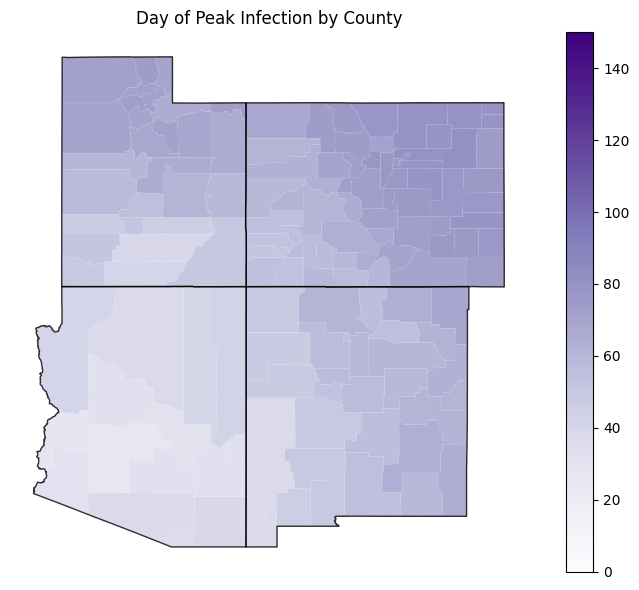

In [3]:
from functools import partial

import numpy as np

from epymorph import *
from epymorph.geo.cache import load_from_cache
from epymorph.initializer import single_location
from epymorph.plots import map_data_by_county

sirh_ipm = ipm_library['sirh']()
geo = load_from_cache('demo-four-states-by-county')
if geo is None:
    raise Exception("Oops, we need to cache the demo geo first (see above cell).")

sim = StandardSimulation(
    geo=geo,
    ipm=sirh_ipm,
    mm=mm_library['centroids'](),
    params={
        'beta': 0.45,
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
        'phi': 40.0,
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Initialize the infection in Maricopa County, Arizona with 10k individuals.
    initializer=partial(single_location, location=7, seed_size=10_000)
)

with sim_messaging(sim):
    output = sim.run()

EVENT_S_TO_I = 0

plot_event(output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array([
    # argmax gives us an index, but the index is equal to the tau step index
    # so just need to floor-div by number of tau steps to get day
    float(np.argmax(output.incidence[:, n, EVENT_S_TO_I])) // output.dim.tau_steps
    for n in range(geo.nodes)
])

map_data_by_county(
    geo=geo,
    data=day_of_peak_infection,
    title='Day of Peak Infection by County',
    vmin=0,
    vmax=output.dim.days,
    cmap='Purples',
    outline='states',
)

## Commuters movement

Now switch to a different movement model, incorporating the Census Bureau's ACS Commuting Flows data, and run the simulation again.

Running simulation (StandardSimulation):
• 2015-01-01 to 2015-05-31 (150 days)
• 141 geo nodes
|####################| 100% 
Runtime: 9.576s


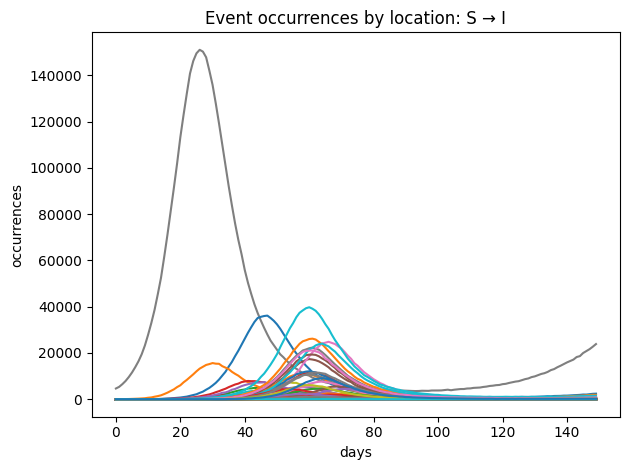

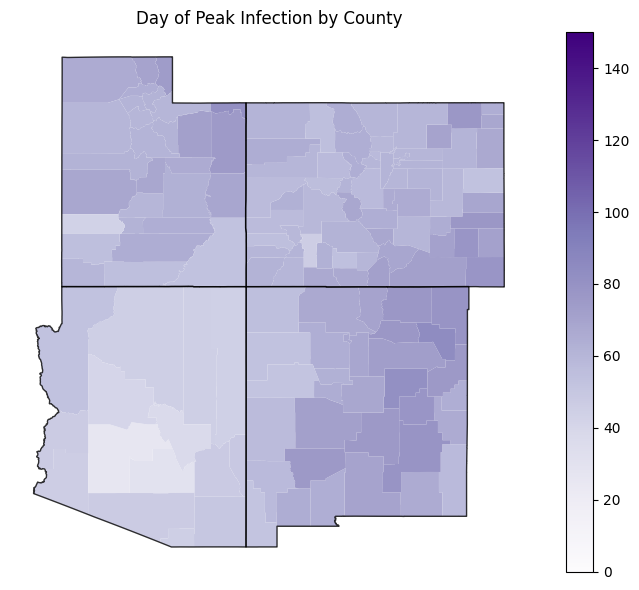

In [3]:
from functools import partial

import numpy as np

from epymorph import *
from epymorph.geo.cache import load_from_cache
from epymorph.initializer import single_location
from epymorph.plots import map_data_by_county

sirh_ipm = ipm_library['sirh']()
geo = load_from_cache('demo-four-states-by-county')
if geo is None:
    raise Exception("Oops, we need to cache the demo geo first (see above cell).")

sim = StandardSimulation(
    geo=geo,
    ipm=sirh_ipm,
    mm=mm_library['pei'](),
    params={
        'beta': 0.45,
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
        'move_control': 0.9,
        'theta': 0.1,
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Initialize the infection in Maricopa County, Arizona with 10k individuals.
    initializer=partial(single_location, location=7, seed_size=10_000)
)

with sim_messaging(sim):
    output = sim.run()

EVENT_S_TO_I = 0

plot_event(output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array([
    # argmax gives us an index, but the index is equal to the tau step index
    # so just need to floor-div by number of tau steps to get day
    float(np.argmax(output.incidence[:, n, EVENT_S_TO_I])) // output.dim.tau_steps
    for n in range(geo.nodes)
])

map_data_by_county(
    geo=geo,
    data=day_of_peak_infection,
    title='Day of Peak Infection by County',
    vmin=0,
    vmax=output.dim.days,
    cmap='Purples',
    outline='states',
)